----------------------------------
# --- Python interface of LIBSVM ---
----------------------------------

Table of Contents
=================

- Introduction
- Installation
- Quick Start
- Design Description
- Data Structures
- Utility Functions
- Additional Information

Introduction
============

Python (http://www.python.org/) is a programming language suitable for rapid
development. This tool provides a simple Python interface to LIBSVM, a library
for support vector machines (http://www.csie.ntu.edu.tw/~cjlin/libsvm). The
interface is very easy to use as the usage is the same as that of LIBSVM. The
interface is developed with the built-in Python library "ctypes."

Installation
============

On Unix systems, type

> make

The interface needs only LIBSVM shared library, which is generated by
the above command. We assume that the shared library is on the LIBSVM
main directory or in the system path.

For windows, the shared library libsvm.dll for 32-bit python is ready
in the directory `..\windows'. You can also copy it to the system
directory (e.g., `C:\WINDOWS\system32\' for Windows XP). To regenerate
the shared library, please follow the instruction of building windows
binaries in LIBSVM README.

Quick Start
===========

There are two levels of usage. The high-level one uses utility functions
in svmutil.py and the usage is the same as the LIBSVM MATLAB interface.

> from svmutil import *

# Read data in LIBSVM format

> y, x = svm_read_problem('../heart_scale')
> m = svm_train(y[:200], x[:200], '-c 4')
> p_label, p_acc, p_val = svm_predict(y[200:], x[200:], m)

# Construct problem in python format
# Dense data

> y, x = [1,-1], [[1,0,1], [-1,0,-1]]

# Sparse data

> y, x = [1,-1], [{1:1, 3:1}, {1:-1,3:-1}]
> prob  = svm_problem(y, x)
> param = svm_parameter('-t 0 -c 4 -b 1')
> m = svm_train(prob, param)

# Precomputed kernel data (-t 4)
# Dense data

> y, x = [1,-1], [[1, 2, -2], [2, -2, 2]]

# Sparse data

> y, x = [1,-1], [{0:1, 1:2, 2:-2}, {0:2, 1:-2, 2:2}]

# isKernel=True must be set for precomputer kernel

> prob  = svm_problem(y, x, isKernel=True)
> param = svm_parameter('-t 4 -c 4 -b 1')
> m = svm_train(prob, param)

# For the format of precomputed kernel, please read LIBSVM README.


# Other utility functions

> svm_save_model('heart_scale.model', m)
> m = svm_load_model('heart_scale.model')
> p_label, p_acc, p_val = svm_predict(y, x, m, '-b 1')
> ACC, MSE, SCC = evaluations(y, p_label)

# Getting online help

> help(svm_train)

The low-level use directly calls C interfaces imported by svm.py. Note that
all arguments and return values are in ctypes format. You need to handle them
carefully.

> from svm import *
> prob = svm_problem([1,-1], [{1:1, 3:1}, {1:-1,3:-1}])
> param = svm_parameter('-c 4')
> m = libsvm.svm_train(prob, param) # m is a ctype pointer to an svm_model

# Convert a Python-format instance to svm_nodearray, a ctypes structure

> x0, max_idx = gen_svm_nodearray({1:1, 3:1})
> label = libsvm.svm_predict(m, x0)

Design Description
==================

There are two files svm.py and svmutil.py, which respectively correspond to
low-level and high-level use of the interface.

In svm.py, we adopt the Python built-in library "ctypes," so that
Python can directly access C structures and interface functions defined
in svm.h.

While advanced users can use structures/functions in svm.py, to
avoid handling ctypes structures, in svmutil.py we provide some easy-to-use
functions. The usage is similar to LIBSVM MATLAB interface.

Data Structures
===============

Four data structures derived from svm.h are svm_node, svm_problem, svm_parameter, 
and svm_model. They all contain fields with the same names in svm.h. Access 
these fields carefully because you directly use a C structure instead of a 
Python object. For svm_model, accessing the field directly is not recommanded. 
Programmers should use the interface functions or methods of svm_model class
in Python to get the values. The following description introduces additional
fields and methods.

Before using the data structures, execute the following command to load the
LIBSVM shared library:

    > from svm import *

- class svm_node:

    Construct an svm_node.

    > node = svm_node(idx, val)

    idx: an integer indicates the feature index.

    val: a float indicates the feature value.

    Show the index and the value of a node.

    > print(node) 

- Function: gen_svm_nodearray(xi [,feature_max=None [,isKernel=False]])

    Generate a feature vector from a Python list/tuple or a dictionary:

    > xi, max_idx = gen_svm_nodearray({1:1, 3:1, 5:-2})

    xi: the returned svm_nodearray (a ctypes structure)

    max_idx: the maximal feature index of xi

    feature_max: if feature_max is assigned, features with indices larger than
                 feature_max are removed.
    
    isKernel: if isKernel == True, the list index starts from 0 for precomputed
              kernel. Otherwise, the list index starts from 1. The default 
	      value is False.

- class svm_problem:

    Construct an svm_problem instance

    > prob = svm_problem(y, x)

    y: a Python list/tuple of l labels (type must be int/double).

    x: a Python list/tuple of l data instances. Each element of x must be
       an instance of list/tuple/dictionary type.

    Note that if your x contains sparse data (i.e., dictionary), the internal
    ctypes data format is still sparse.

    For pre-computed kernel, the isKernel flag should be set to True:

    > prob = svm_problem(y, x, isKernel=True)

    Please read LIBSVM README for more details of pre-computed kernel.

- class svm_parameter:

    Construct an svm_parameter instance

    > param = svm_parameter('training_options')

    If 'training_options' is empty, LIBSVM default values are applied.

    Set param to LIBSVM default values.

    > param.set_to_default_values()

    Parse a string of options.

    > param.parse_options('training_options')

    Show values of parameters.

    > print(param)

- class svm_model:

    There are two ways to obtain an instance of svm_model:

    > model = svm_train(y, x)
    > model = svm_load_model('model_file_name')

    Note that the returned structure of interface functions
    libsvm.svm_train and libsvm.svm_load_model is a ctypes pointer of
    svm_model, which is different from the svm_model object returned
    by svm_train and svm_load_model in svmutil.py. We provide a
    function toPyModel for the conversion:

    > model_ptr = libsvm.svm_train(prob, param)
    > model = toPyModel(model_ptr)

    If you obtain a model in a way other than the above approaches,
    handle it carefully to avoid memory leak or segmentation fault.

    Some interface functions to access LIBSVM models are wrapped as
    members of the class svm_model:

    > svm_type = model.get_svm_type()
    > nr_class = model.get_nr_class()
    > svr_probability = model.get_svr_probability()
    > class_labels = model.get_labels()
    > sv_indices = model.get_sv_indices()
    > nr_sv = model.get_nr_sv()
    > is_prob_model = model.is_probability_model()
    > support_vector_coefficients = model.get_sv_coef()
    > support_vectors = model.get_SV() 

Utility Functions
=================

To use utility functions, type

    > from svmutil import *

The above command loads
    svm_train()        : train an SVM model
    svm_predict()      : predict testing data
    svm_read_problem() : read the data from a LIBSVM-format file.
    svm_load_model()   : load a LIBSVM model.
    svm_save_model()   : save model to a file.
    evaluations()      : evaluate prediction results.

- Function: svm_train

    There are three ways to call svm_train()

    > model = svm_train(y, x [, 'training_options'])
    > model = svm_train(prob [, 'training_options'])
    > model = svm_train(prob, param)

    y: a list/tuple of l training labels (type must be int/double).

    x: a list/tuple of l training instances. The feature vector of
       each training instance is an instance of list/tuple or dictionary.

    training_options: a string in the same form as that for LIBSVM command
                      mode.

    prob: an svm_problem instance generated by calling
          svm_problem(y, x).
	  For pre-computed kernel, you should use
	  svm_problem(y, x, isKernel=True)

    param: an svm_parameter instance generated by calling
           svm_parameter('training_options')

    model: the returned svm_model instance. See svm.h for details of this
           structure. If '-v' is specified, cross validation is
           conducted and the returned model is just a scalar: cross-validation
           accuracy for classification and mean-squared error for regression.

    To train the same data many times with different
    parameters, the second and the third ways should be faster..

    Examples:

    > y, x = svm_read_problem('../heart_scale')
    > prob = svm_problem(y, x)
    > param = svm_parameter('-s 3 -c 5 -h 0')
    > m = svm_train(y, x, '-c 5')
    > m = svm_train(prob, '-t 2 -c 5')
    > m = svm_train(prob, param)
    > CV_ACC = svm_train(y, x, '-v 3')

- Function: svm_predict

    To predict testing data with a model, use

    > p_labs, p_acc, p_vals = svm_predict(y, x, model [,'predicting_options'])

    y: a list/tuple of l true labels (type must be int/double). It is used
       for calculating the accuracy. Use [0]*len(x) if true labels are
       unavailable.

    x: a list/tuple of l predicting instances. The feature vector of
       each predicting instance is an instance of list/tuple or dictionary.

    predicting_options: a string of predicting options in the same format as
                        that of LIBSVM.

    model: an svm_model instance.

    p_labels: a list of predicted labels

    p_acc: a tuple including accuracy (for classification), mean
           squared error, and squared correlation coefficient (for
           regression).

    p_vals: a list of decision values or probability estimates (if '-b 1'
            is specified). If k is the number of classes in training data, 
	    for decision values, each element includes results of predicting 
	    k(k-1)/2 binary-class SVMs. For classification, k = 1 is a 
	    special case. Decision value [+1] is returned for each testing
	    instance, instead of an empty list.
	    For probabilities, each element contains k values indicating
            the probability that the testing instance is in each class.
            Note that the order of classes is the same as the 'model.label'
            field in the model structure.

    Example:

    > m = svm_train(y, x, '-c 5')
    > p_labels, p_acc, p_vals = svm_predict(y, x, m)

- Functions:  svm_read_problem/svm_load_model/svm_save_model

    See the usage by examples:

    > y, x = svm_read_problem('data.txt')
    > m = svm_load_model('model_file')
    > svm_save_model('model_file', m)

- Function: evaluations

    Calculate some evaluations using the true values (ty) and predicted
    values (pv):

    > (ACC, MSE, SCC) = evaluations(ty, pv)

    ty: a list of true values.

    pv: a list of predict values.

    ACC: accuracy.

    MSE: mean squared error.

    SCC: squared correlation coefficient.


Additional Information
======================

This interface was written by Hsiang-Fu Yu from Department of Computer
Science, National Taiwan University. If you find this tool useful, please
cite LIBSVM as follows

Chih-Chung Chang and Chih-Jen Lin, LIBSVM : a library for support
vector machines. ACM Transactions on Intelligent Systems and
Technology, 2:27:1--27:27, 2011. Software available at
http://www.csie.ntu.edu.tw/~cjlin/libsvm

For any question, please contact Chih-Jen Lin <cjlin@csie.ntu.edu.tw>,
or check the FAQ page:

http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html


cyb.csv
hs300.csv
sh.csv
sz.csv
sz50.csv
zxb.csv


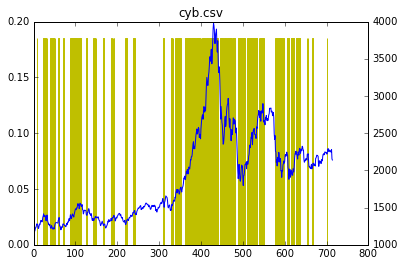

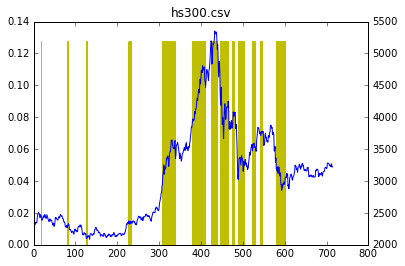

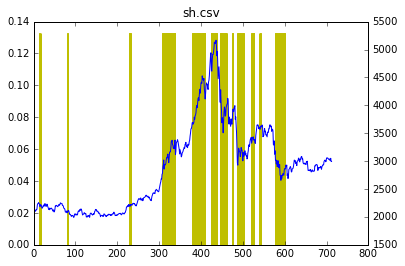

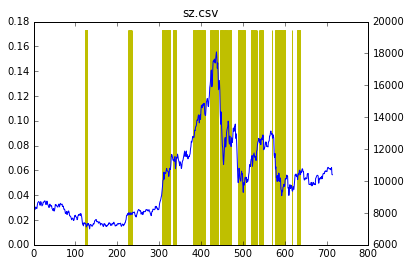

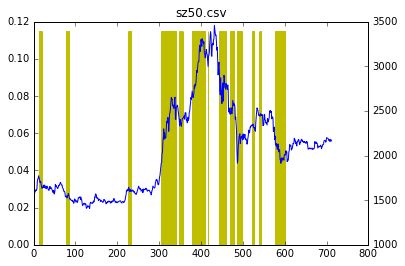

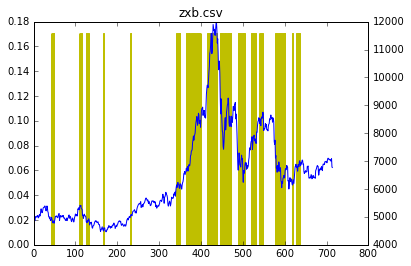

In [17]:
%matplotlib inline
import os
import os.path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ma10 = 10
ma20 = 20
feature_len = 5


def normalize(feature):
    mn = min(feature)
    mx = max(feature)
    return [(feature[i]-mn)/(mx-mn) for i in range(len(feature))]


def plot_dataframe(title, df):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    #ax1.plot(df['ma_twist_incr'].tolist()[::-1], color='red')
    ax2.plot(df['close'].tolist()[::-1])
    label = [max(df['ma_twist_incr']) if df['label'][i]==1 else 0 for i in range(len(df))][::-1]
    ax1.bar(range(len(df.index)), label, color='y', edgecolor='y')
    ax1.set_title(title)
    

def write_libsvm_files(target_file, df):
    target_file = target_file.replace('.csv', '.lsvm')
    fhandle = open(target_file, 'w')
    
    df_length = len(df.index)
    normalize_feature = normalize(df['close'])
    for i in range(df_length-feature_len):
        label = str(df['label'][i])
        feature = tuple(normalize_feature[i+1:i+feature_len+1])
        fhandle.write(label+' ')
        for j in range(feature_len):
            fhandle.write(str(j+1)+':'+str(feature[j])+' ')
        fhandle.write('\n')
    fhandle.close

    
def proceed_file(target_file, file):

    df = pd.read_csv(file)
    df = df.drop(['open','high','low','volume','price_change','p_change'], axis=1)
    ma_short = list(pd.rolling_mean(df['close'],ma10)[ma10-1:]) + [-1]*(ma10-1)
    df['ma_short'] = ma_short
    
    ma_long = list(pd.rolling_mean(df['close'],ma20)[ma20-1:]) + [-1]*(ma20-1)
    df['ma_long'] = ma_long
    df = df[df['ma_long']!=-1]
    
    df['ma_twist'] = abs(df['ma_short'] - df['ma_long'])/df['ma_long']
    df['ma_incr']  = [abs(df['ma_short'][i] - df['ma_short'][i+1])/df['ma_short'][i] for i in range(len(df.index)-1)] + [-1]
    df = df[df['ma_incr']!=-1]
    
    df['ma_twist_incr'] = df['ma_twist'] + df['ma_incr']
    df['label'] = [(1 if df['ma_twist_incr'][i] > 0.03 else -1) for i in range(len(df.index))]
    
    df.to_csv(target_file)
    
    title = target_file.split('/')[-1]
    print(title)
    plot_dataframe(title, df)
    
    write_libsvm_files(target_file, df)
    
    
if __name__ == '__main__':
    rootdir = 'E:\\stock_data\\indices'
    target_dir = 'E:/stock_data/stocks_for_svm/'
    for parent,dirnames,filenames in os.walk(rootdir):
        for filename in filenames:
            file = os.path.join(parent, filename)
            target_file = target_dir + filename
            proceed_file(target_file, file)
        


Accuracy = 77.1144% (155/201) (classification)


<Container object of 509 artists>

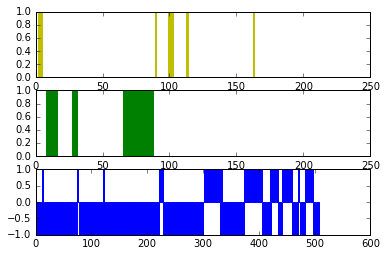

In [34]:
from libsvm.svmutil import *
%matplotlib inline
import os
import os.path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
y, x = svm_read_problem('E:/stock_data/stocks_for_svm/hs300.lsvm')

testy, testx = y[200::-1], x[200::-1]
trainy,trainx = y[:200:-1], x[:200:-1]
para = svm_parameter('-c 64 -g 4  -w1 1 -w-1 2')
prob = svm_problem(trainy, trainx)
m = svm_train(prob, para)

p_labels, p_acc, p_vals = svm_predict(testy, testx, m)

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
label = [1 if p_labels[i]==1 else 0 for i in range(len(p_labels))]
label2 = [1 if testy[i]==1 else 0 for i in range(len(testy))]
ax1.bar(range(len(testy)), label, color='y', edgecolor='y')
ax2.bar(range(len(testy)), label2, color='g', edgecolor='g')
ax3.bar(range(len(trainy)), trainy, color='b', edgecolor='b')